### Linear regression I 
This notebook demostrates:
1. Linear regression coefficient estimates are unbiased under assumptions
2. How to construct bootstrap confidence intervals around coefficient estimates
3. Residual plot
4. Q-Q plot

### 1. Linear regression coefficient estimates are unbiased under assumptions

In [1]:
import numpy as np
import matplotlib.pyplot as plt


### Statsmodels is the statistical modeling package in python

In [2]:
import statsmodels.api as sm

In [3]:
#Randomly draw X and error
x = np.random.randn(1000) # ~ N(0,1) 
e = np.random.randn(1000) # ~ N(0,1)

### Define a linear relationship with some disturbance (noise)

In [4]:
#b0 = 10
#b1 = 4
y = 10 + 4*x + e

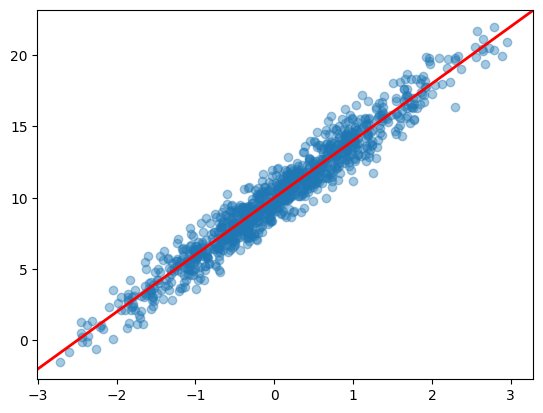

In [5]:
plt.scatter(x,y,alpha=0.4)

plt.axline((0, 10), (3, 22), linewidth=2, color='r')

In [6]:
x_cons = sm.add_constant(x)
    
model = sm.OLS(y,x_cons).fit()

Summary of the linear regression results

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 1.678e+04
Date:                Wed, 07 Feb 2024   Prob (F-statistic):               0.00
Time:                        19:25:57   Log-Likelihood:                -1394.3
No. Observations:                1000   AIC:                             2793.
Df Residuals:                     998   BIC:                             2802.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9372      0.031    321.228      0.000       9.876       9.998
x1             4.0251      0.031    129.541      0.000       3.964       4.086
==============================================================================
Omnibus:                        1.647   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.671
Skew:                           0.098   Prob(JB):                        0.434
Kurtosis:                       2.963   Cond. No.                         1.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Test unbiasedness

In [8]:
def reg_unbiased(x,y):
    
    estimates_list = []
    
    #Repeat the sampling process for 10,000 times
    for i in range(10000):
        #Get a random index
        sample_index = np.random.choice(1000, 300)
        
        #Use the index to index y and x
        sample_y = y[sample_index]
        sample_x = x[sample_index]
        
        #add constant to x
        sample_x = sm.add_constant(sample_x)
    
        #Fit the OLS
        model = sm.OLS(sample_y,sample_x).fit()
        
        #Append the parameters
        estimates_list.append(model.params)
        
    return np.array(estimates_list)

In [9]:
rslt = np.array(reg_unbiased(x,y))

In [10]:
rslt

array([[9.98692129, 4.0672853 ],
       [9.93114785, 4.03665871],
       [9.99781954, 4.10916308],
       ...,
       [9.91294925, 3.98044767],
       [9.88729838, 3.992089  ],
       [9.87920183, 4.12874911]])

In [11]:
np.mean(rslt,axis=0)

array([9.93654559, 4.02654646])

The average of the estimates from 10000 repetitions is equivelant to the true regression line with intercept of 10 and slope of 4.

### 2. How to construct confidence intervals around coefficient estimates

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import *
import statsmodels.formula.api as smf


#Use the mgp dataset
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv'

df = pd.read_csv(url)
df = df.dropna()

If you work on a `pandas.DataFrame`, you can use this interface to fit a model

In [13]:
model = smf.ols(formula='acceleration ~ horsepower', data=df).fit()
subsample_coef = model.params

In [14]:
subsample_coef.values[0]

20.701933699127174

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           acceleration   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     352.8
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           1.58e-56
Time:                        19:25:58   Log-Likelihood:                -827.24
No. Observations:                 392   AIC:                             1658.
Df Residuals:                     390   BIC:                             1666.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.7019      0.293     70.717      0.000      20.126      21.277
horsepower    -0.0494      0.003    -18.784      0.000      -0.055      -0.044
==============================================================================
Omnibus:                       29.904   Durbin-Watson:                   1.483
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.989
Skew:                           0.608   Prob(JB):                     5.63e-09
Kurtosis:                       3.919   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Bootstrap samples with replacement from the dataframe

In [16]:
#Define a bootstrap CI function
def bootstrap_ci(df):
    np.random.seed(100)
    bootstrap_b0 = []
    bootstrap_b1 = []
    
    for i in range(1000):
        #generate a re-sample with the original sample size, with replacement
        sample = df.sample(len(df), replace=True)
        
        #formulate the model 
        model = smf.ols(formula='acceleration ~ horsepower', data=sample).fit()
        
        #Get the intercept and slope estimates
        subsample_coef = model.params

        #Append them to the list
        bootstrap_b0.append(subsample_coef.values[0])
        bootstrap_b1.append(subsample_coef.values[1])
    
    #Get the lower and upper bound for the middle 95%:
    b0_CI = [np.percentile(bootstrap_b0, 2.5),
          np.percentile(bootstrap_b0, 97.5)]
    
    b1_CI = [np.percentile(bootstrap_b1, 2.5),
          np.percentile(bootstrap_b1, 97.5)]
    
    return b0_CI,b1_CI
    

In [17]:
rslt = bootstrap_ci(df)

In [18]:
print("95% CI for intercept:",rslt[0])

95% CI for intercept: [20.017892056783964, 21.347498114044548]


In [19]:
print("95% CI for slope:",rslt[1])

95% CI for slope: [-0.0548220191942679, -0.043592380423869134]


<Axes: xlabel='horsepower', ylabel='acceleration'>

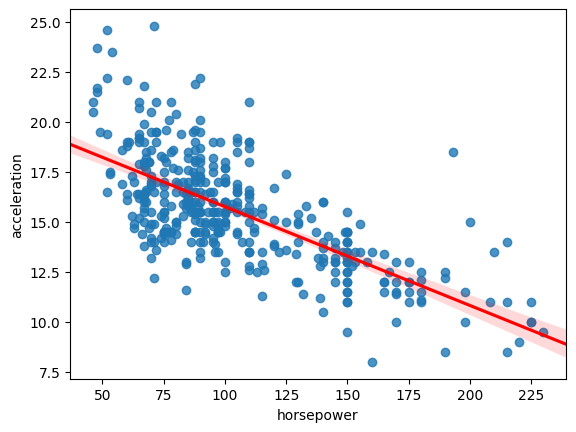

In [20]:
import seaborn as sns

sns.regplot(data=df, x="horsepower", y="acceleration", ci=95, truncate=False,line_kws={"color": "red"})

#plt.xlim(300)

### 3. Residual plot

Text(0, 0.5, 'Residuals')

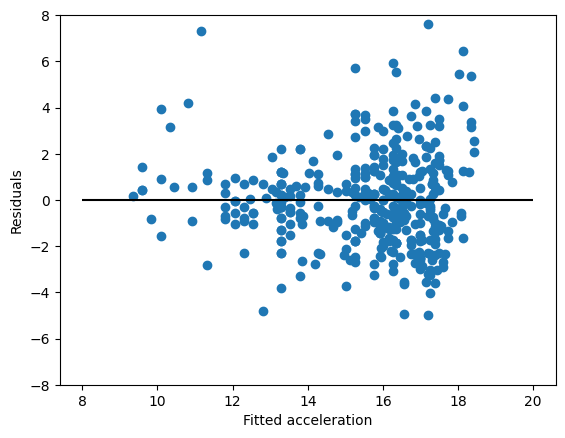

In [21]:
plt.scatter(model.predict(),model.resid)
plt.hlines(0,8,20,color="black")
plt.ylim(-8,8)
plt.xlabel("Fitted acceleration")
plt.ylabel("Residuals")

### 4. Q-Q Plot

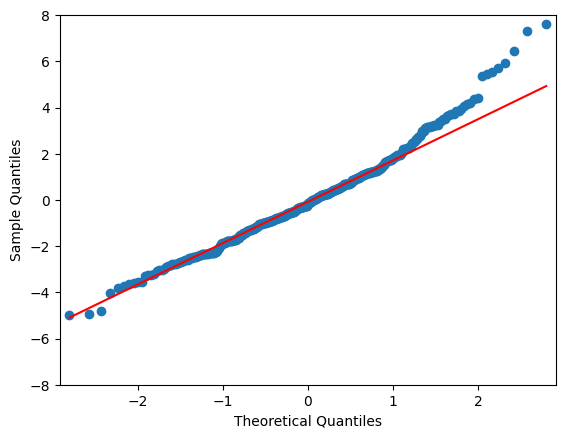

In [22]:
res = model.resid
fig = sm.qqplot(res,line='q')
#plt.xlim(-8,8)
plt.ylim(-8,8)
plt.show()

(array([  5.,  29.,  69., 106., 102.,  40.,  25.,   8.,   5.,   3.]),
 array([-4.99465643, -3.73465643, -2.47465643, -1.21465643,  0.04534357,
         1.30534357,  2.56534357,  3.82534357,  5.08534357,  6.34534357,
         7.60534357]),
 <BarContainer object of 10 artists>)

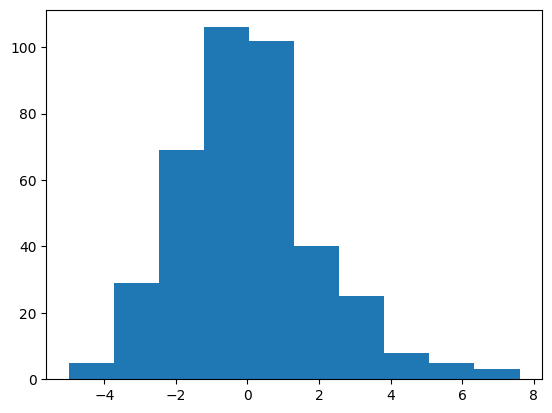

In [23]:
plt.hist(model.resid)